# MainQuest_01

### Transformer와 GPT 논문의 모델 간 변경 사항

1. **Transformer와 GPT 비교**  
   - Transformer는 Encoder-Decoder 구조를 사용하지만, GPT는 Decoder만 사용합니다.
   - Transformer Decoder는 Masked Self attention, encoder-decoder attention 2가지를 사용하지만
   - GPT는 Masked Self attention 만 사용합니다.
   - GPT는 언어 모델링(다음 토큰 예측)을 목표로 하며, Transformer는 다양한 NLP 작업에 더 일반적으로 사용됩니다.
  
  
  
2. **아키텍처 수정 및 변경내용**  
    - GPT는 인코더-디코더 구조를 사용하지 않으며, 오직 디코더만 사용하는 언어 생성 모델
    - 따라서 인코더 출력(enc_outputs)을 필요로 하지 않음
    - 인코더 입력과 관련된 패딩 처리가 필요 없으므로, dec_padding_mask는 사용되지 않음
    - 입력 시퀀스의 현재 토큰 이후 토큰을 마스킹하여 사용
    - 입력 데이터에 위치 정보 추가: 위치 임베딩(Position Embedding)을 추가
    - 출력 계층에서 Softmax를 통해 다음 토큰의 확률 분포를 계산.
        
  
확인 필요 사항 : 패딩 처리는 look_ahead_mask로 충분
- GPT의 디코더는 **look_ahead_mask**를 사용하여 입력 시퀀스에서 미래 정보를 차단하고, 패딩 토큰을 무시
- look_ahead_mask는 패딩 토큰(0)을 포함한 모든 불필요한 토큰을 어텐션에서 제외
- 따라서 추가적으로 dec_padding_mask를 사용할 필요가 없음

### 데이터 형태 변경  
    - GPT는 next tokecn 예측(Language Modeling)을 목표로 하기 때문에 입력과 출력 모두 동일한 텍스트 시퀀스에서 처리됩니다.
    - 입력 시퀀스는 [START_TOKEN] + 텍스트 + [END_TOKEN]의 형태로 구성되고, 출력은 다음 토큰을 예측하도록 설계됩니다.  
    ==> <Delim> 토큰을 활용하여 질문과 답변을 연결할 수 있도록 수정 하였습니다.
  
### 데이터셋 준비
    - 입력 데이터와 동일한 텍스트 시퀀스를 GPT 학습용 데이터셋으로 준비.
    - GPT의 목표는 토큰 시퀀스에서 다음 토큰을 예측하는 것이므로 inputs와 labels 모두 동일한 시퀀스를 사용.

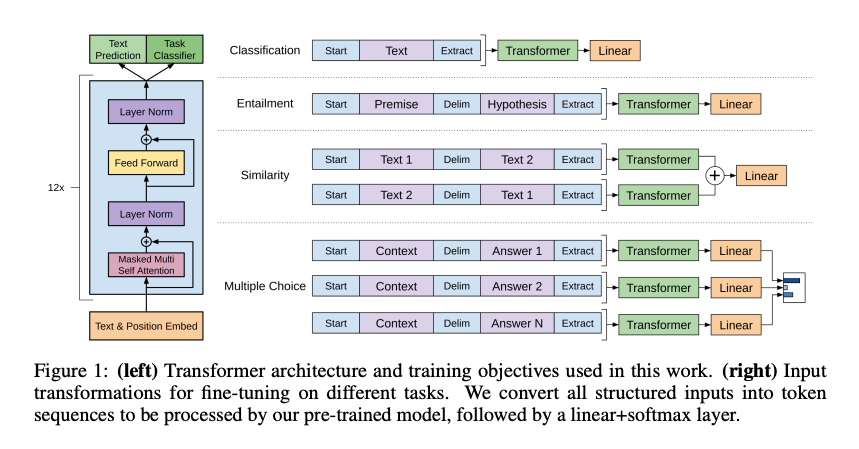

### Step 1. 데이터 수집하기
---
한국어 챗봇 데이터는 송영숙님이 공개한 챗봇 데이터를 사용합니다.

이 데이터는 아래의 링크에서 다운로드할 수 있습니다.

- songys/Chatbot_data  
https://github.com/songys/Chatbot_data/blob/master/ChatbotData.csv  

Cloud shell에서 아래 명령어를 입력해 주세요.

```
$ mkdir -p ~/aiffel/transformer_chatbot/data/
$ ln -s ~/data/* ~/aiffel/transformer_chatbot/data/
```

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import numpy as np
import re

In [2]:
# 파일 경로
file_path = '~/aiffel/transformer_chatbot/data/ChatbotData .csv'

### 파일 이름에 띄어쓰기가 있었음!! 챗봇 데이터 github 에도 내용 있음...
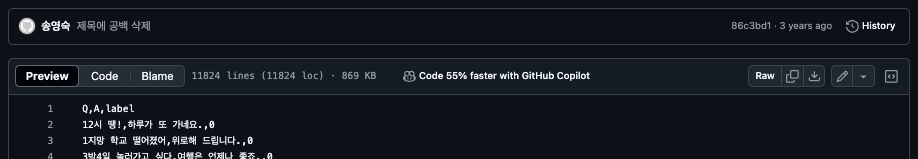

### 이 프로젝트에서는 질문과 답변 쌍만 사용하여 모델을 학습시키고, label 정보는 사용하지 않음
- label이 모델 학습에 필요하지 않음
- 이 프로젝트의 목표는 주어진 질문(Q)에 대해 답변(A)을 생성 하는것
- 모델 복잡도 감소
- 감정 기반 챗봇이나 대화 유형에 따른 답변 생성을 목표로 하는 경우 필요함

In [3]:
# 1. 데이터 로드
def load_korean_data(file_path):
    # 데이터 로드
    data = pd.read_csv(file_path)
    print("전체 데이터 수:", len(data))
    print(data.head())
    data = data[['Q', 'A']]  # 질문과 답변만 사용
    data = data.dropna()  # 결측값 제거
    return data['Q'].tolist(), data['A'].tolist()

In [4]:
questions, answers = load_korean_data(file_path)

전체 데이터 수: 11823
                 Q            A  label
0           12시 땡!   하루가 또 가네요.      0
1      1지망 학교 떨어졌어    위로해 드립니다.      0
2     3박4일 놀러가고 싶다  여행은 언제나 좋죠.      0
3  3박4일 정도 놀러가고 싶다  여행은 언제나 좋죠.      0
4          PPL 심하네   눈살이 찌푸려지죠.      0


In [5]:
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


In [6]:
# 결과 확인
print("샘플 질문:", questions[:5])
print("샘플 답변:", answers[:5])

샘플 질문: ['12시 땡!', '1지망 학교 떨어졌어', '3박4일 놀러가고 싶다', '3박4일 정도 놀러가고 싶다', 'PPL 심하네']
샘플 답변: ['하루가 또 가네요.', '위로해 드립니다.', '여행은 언제나 좋죠.', '여행은 언제나 좋죠.', '눈살이 찌푸려지죠.']


### Step 2. 데이터 전처리하기
---
영어 데이터와는 전혀 다른 데이터인 만큼 영어 데이터에 사용했던 전처리와 일부 동일한 전처리도 필요하겠지만 전체적으로는 다른 전처리를 수행해야 할 수도 있습니다.

In [7]:
MAX_SAMPLES = 50000  # 사용할 최대 샘플 수
MAX_LENGTH = 40  # 최대 시퀀스 길이

In [8]:
# 2. 전처리 함수
def preprocess_sentence(sentence):
    # 특수문자 제거
    sentence = re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z0-9?.!,]+", " ", sentence)
    # 공백 제거
    sentence = re.sub(r"\s+", " ", sentence)
    sentence = sentence.strip()
    return sentence

In [9]:
# 2. 데이터 전처리
def preprocess_data(questions, answers):
    # 전처리 적용
    questions = [preprocess_sentence(q) for q in questions]
    answers = [preprocess_sentence(a) for a in answers]
    return questions, answers

In [10]:
# 전처리 함수 Test
sentence = "안녕하세요! 123  #^^*& Test"
preprocessed = preprocess_sentence(sentence)
print(preprocessed)

안녕하세요! 123 Test


In [11]:
questions, answers = preprocess_data(questions, answers)

### Step 3. SubwordTextEncoder 사용하기
---
한국어 데이터는 형태소 분석기를 사용하여 토크나이징을 해야 한다고 많은 분이 알고 있습니다. 하지만 여기서는 형태소 분석기가 아닌 위 실습에서 사용했던 내부 단어 토크나이저인 SubwordTextEncoder를 그대로 사용해보세요.

In [12]:
# 3. SubwordTextEncoder 생성
def create_tokenizer(questions, answers, vocab_size=2**13):
    corpus = questions + answers
    tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
        corpus, target_vocab_size=vocab_size
    )
    return tokenizer

In [13]:
tokenizer = create_tokenizer(questions, answers)

### GPT 모델용 정수 인코딩 및 패딩
- GPT 모델에서는 질문과 답변 데이터를 따로 처리하지 않고, 하나의 시퀀스로 결합하여 입력으로 사용
- 시작 및 종료 토큰을 추가하고, 길이 제한 및 패딩 처리.

In [14]:
# 질문과 답변의 길이 계산
question_lengths = [len(tokenizer.encode(q)) for q in questions]
answer_lengths = [len(tokenizer.encode(a)) for a in answers]

# 결합된 데이터의 길이 계산
combined_lengths = [q_len + a_len for q_len, a_len in zip(question_lengths, answer_lengths)]

# 길이 통계 출력
print("질문 평균 길이:", sum(question_lengths) / len(question_lengths))
print("답변 평균 길이:", sum(answer_lengths) / len(answer_lengths))
print("결합된 데이터 평균 길이:", sum(combined_lengths) / len(combined_lengths))
print("결합된 데이터 최대 길이:", max(combined_lengths))

질문 평균 길이: 5.494544531844709
답변 평균 길이: 5.818912289605008
결합된 데이터 평균 길이: 11.313456821449718
결합된 데이터 최대 길이: 38


In [15]:
# # 시작 및 종료 토큰 정의
# START_TOKEN = [tokenizer.vocab_size]  # 시작 토큰은 어휘 크기 뒤에 추가
# END_TOKEN = [tokenizer.vocab_size + 1]  # 종료 토큰은 어휘 크기 + 1
# VOCAB_SIZE = tokenizer.vocab_size + 2  # 시작 및 종료 토큰 포함
# print("단어장의 크기:", VOCAB_SIZE)

In [16]:
# # 4. GPT 모델용 데이터 전처리
# def encode_and_filter_gpt(data, tokenizer, max_length):
#     # 시작 및 종료 토큰 정의
#     START_TOKEN = [tokenizer.vocab_size]
#     END_TOKEN = [tokenizer.vocab_size + 1]

#     # 필터링된 데이터를 저장할 리스트
#     filtered_data = []

#     for sentence in data:
#         # 시작 및 종료 토큰 추가
#         encoded_sentence = START_TOKEN + tokenizer.encode(sentence) + END_TOKEN

#         # 최대 길이를 초과하지 않는 데이터만 추가
#         if len(encoded_sentence) <= max_length:
#             filtered_data.append(encoded_sentence)

#     # 패딩 처리
#     padded_data = tf.keras.preprocessing.sequence.pad_sequences(
#         filtered_data, maxlen=max_length, padding='post'
#     )

#     return padded_data, START_TOKEN, END_TOKEN

In [17]:
# # 질문과 답변 결합
# combined_data = questions + answers

# # GPT 모델용 데이터 전처리
# inputs, START_TOKEN, END_TOKEN = encode_and_filter_gpt(combined_data, tokenizer, MAX_LENGTH)

# print(f"전처리된 데이터 샘플 수: {len(inputs)}")
# print(f"시작 토큰 ID: {START_TOKEN}")
# print(f"종료 토큰 ID: {END_TOKEN}")

###  \<Delim> 토큰을 활용하여 질문과 답변을 연결할 수 있도록 수정하였음
- 이 토큰을 사용하면 모델이 질문과 답변 사이의 관계를 명확히 이해할 수 있음
- 전처리 과정에 Delim 토큰을 추가하는 방식으로 코드를 개선

In [18]:
def encode_and_filter_gpt_with_delim(questions, answers, tokenizer, max_length):
    """
    질문과 답변 데이터를 <Delim> 토큰으로 결합하고 GPT 모델용 데이터로 전처리합니다.
    
    Args:
        questions (list): 질문 데이터 리스트
        answers (list): 답변 데이터 리스트
        tokenizer (Tokenizer): 토크나이저 객체
        max_length (int): 데이터의 최대 길이
    
    Returns:
        tuple: (패딩된 데이터, 시작 토큰, 종료 토큰, Delim 토큰)
    """
    # 특수 토큰을 수동으로 추가
    START_TOKEN = [tokenizer.vocab_size]  # 시작 토큰
    END_TOKEN = [tokenizer.vocab_size + 1]  # 종료 토큰
    DELIM_TOKEN = [tokenizer.vocab_size + 2]  # Delim 토큰

    # 필터링된 데이터를 저장할 리스트
    filtered_data = []

    for question, answer in zip(questions, answers):
        # 질문과 답변을 <Delim> 토큰으로 연결
        combined_sentence = (
            START_TOKEN + 
            tokenizer.encode(question) + 
            DELIM_TOKEN + 
            tokenizer.encode(answer) + 
            END_TOKEN
        )

        # 최대 길이를 초과하지 않는 데이터만 추가
        if len(combined_sentence) <= max_length:
            filtered_data.append(combined_sentence)

    # 패딩 처리
    padded_data = tf.keras.preprocessing.sequence.pad_sequences(
        filtered_data, maxlen=max_length, padding='post'
    )

    return padded_data, START_TOKEN, END_TOKEN, DELIM_TOKEN

In [19]:
# # 시작 및 종료 토큰 정의
# START_TOKEN = [tokenizer.vocab_size]
# END_TOKEN = [tokenizer.vocab_size + 1]
# DELIM_TOKEN = [tokenizer.vocab_size + 2]
VOCAB_SIZE = tokenizer.vocab_size + 3
print("단어장의 크기:", VOCAB_SIZE)

단어장의 크기: 8171


In [20]:
# 질문과 답변 데이터 준비
combined_data = (questions, answers)

# GPT 모델용 데이터 전처리
inputs, START_TOKEN, END_TOKEN, DELIM_TOKEN = encode_and_filter_gpt_with_delim(
    questions, answers, tokenizer, MAX_LENGTH
)

In [21]:
print("전처리된 데이터:", inputs)
print("시작 토큰 ID:", START_TOKEN)
print("종료 토큰 ID:", END_TOKEN)
print("Delim 토큰 ID:", DELIM_TOKEN)
print(f"전처리된 데이터 샘플 수: {len(inputs)}")

전처리된 데이터: [[8168 7906 4199 ...    0    0    0]
 [8168 7961   44 ...    0    0    0]
 [8168 7963 1432 ...    0    0    0]
 ...
 [8168 8149 8069 ...    0    0    0]
 [8168  131  163 ...    0    0    0]
 [8168 1949  881 ...    0    0    0]]
시작 토큰 ID: [8168]
종료 토큰 ID: [8169]
Delim 토큰 ID: [8170]
전처리된 데이터 샘플 수: 11822


### 아래는 기존 TransFomer 에 사용했던 원본 코드(주석 처리함)

In [22]:
# # 4. 정수 인코딩 및 시작/종료 토큰 추가
# def encode_and_pad(questions, answers, tokenizer, max_length):
#     # 시작 및 종료 토큰 정의
#     START_TOKEN = [tokenizer.vocab_size]  # 시작 토큰은 어휘 크기 뒤에 추가
#     END_TOKEN = [tokenizer.vocab_size + 1]  # 종료 토큰은 어휘 크기 + 1

#     # 길이 제한을 적용하여 시작 및 종료 토큰 추가
#     filtered_questions = []
#     filtered_answers = []

#     for q, a in zip(questions, answers):
#         # 질문과 답변 각각에 시작 및 종료 토큰 추가
#         encoded_q = START_TOKEN + tokenizer.encode(q) + END_TOKEN
#         encoded_a = START_TOKEN + tokenizer.encode(a) + END_TOKEN

#         # 최대 길이를 초과하지 않는 데이터만 추가
#         if len(encoded_q) <= max_length and len(encoded_a) <= max_length:
#             filtered_questions.append(encoded_q)
#             filtered_answers.append(encoded_a)

#     # 패딩 처리
#     questions = pad_sequences(filtered_questions, maxlen=max_length, padding='post')
#     answers = pad_sequences(filtered_answers, maxlen=max_length, padding='post')

#     return questions, answers, START_TOKEN, END_TOKEN

In [23]:
# # 4. 정수 인코딩 및 패딩 처리
# questions, answers, START_TOKEN, END_TOKEN = encode_and_pad(
#     questions, answers, tokenizer, MAX_LENGTH
# )

In [24]:
# print('단어장의 크기 :',(VOCAB_SIZE))
# print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
# print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

### Teacher Forcing 사용

- TensorFlow Dataset 생성
    - 입력(inputs)과 출력(labels) 모두 동일한 시퀀스를 사용.
    - 입력은 시퀀스의 처음부터 마지막-1까지, 출력은 시퀀스의 두 번째부터 마지막까지 설정.
    - 논문에서 언급된 언어 모델링 목표는 “주어진 문맥에서 다음 토큰을 예측”하는 것
    - 이 데이터셋은 Transformer 디코더가 다음 토큰을 예측하도록 설계

In [25]:
# 5. TensorFlow Dataset 생성
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# GPT 학습용 TensorFlow Dataset 생성
dataset = tf.data.Dataset.from_tensor_slices((
    inputs[:, :-1],  # inputs: [START_TOKEN, ...]
    inputs[:, 1:]    # labels: [..., END_TOKEN]
))
dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

print(f"데이터셋 준비 완료: {len(inputs)}개의 샘플")
print("예제 데이터셋:", next(iter(dataset)))

데이터셋 준비 완료: 11822개의 샘플
예제 데이터셋: (<tf.Tensor: shape=(64, 39), dtype=int32, numpy=
array([[8168, 4036, 2667, ...,    0,    0,    0],
       [8168,  415, 1125, ...,    0,    0,    0],
       [8168, 1955,   22, ...,    0,    0,    0],
       ...,
       [8168, 3098,  318, ...,    0,    0,    0],
       [8168,  270, 8148, ...,    0,    0,    0],
       [8168,  233,  182, ...,    0,    0,    0]], dtype=int32)>, <tf.Tensor: shape=(64, 39), dtype=int32, numpy=
array([[4036, 2667,  157, ...,    0,    0,    0],
       [ 415, 1125, 1157, ...,    0,    0,    0],
       [1955,   22,  771, ...,    0,    0,    0],
       ...,
       [3098,  318,  276, ...,    0,    0,    0],
       [ 270, 8148, 8050, ...,    0,    0,    0],
       [ 233,  182,  722, ...,    0,    0,    0]], dtype=int32)>)


### 아래는 기존 TransFomer 에 사용했던 원본 코드(주석 처리함)

In [26]:
# # 5. TensorFlow Dataset 생성
# BATCH_SIZE = 64
# BUFFER_SIZE = 20000

# dataset = tf.data.Dataset.from_tensor_slices((
#     {
#         'inputs': questions,
#         'dec_inputs': answers[:, :-1]
#     },
#     {
#         'outputs': answers[:, 1:]
#     },
# ))
# dataset = dataset.cache()
# dataset = dataset.shuffle(BUFFER_SIZE)
# dataset = dataset.batch(BATCH_SIZE)
# dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

# print(f"데이터셋 준비 완료: {len(questions)}개의 샘플")
# print("예제 데이터셋:", next(iter(dataset)))

### Step 4. 모델 구성하기

In [27]:
import matplotlib.pyplot as plt

### 포지셔널 인코딩
- 논문에서 사용된 **포지셔널 인코딩 (W_p)**

In [28]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

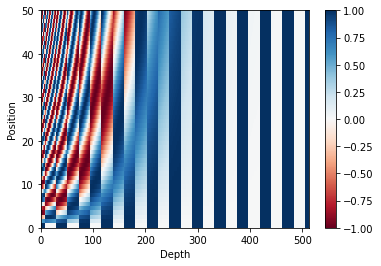

In [29]:
# Test
sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [30]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

### 멀티-헤드 어텐션

In [31]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth)) # [batch_size, seq_len, num_heads, depth] 
    return tf.transpose(inputs, perm=[0, 2, 1, 3]) # [batch_size, num_heads, seq_len, depth] 

  def call(self, inputs):
    # inputs는 딕셔너리 형태로 전달
    # query: Query 텐서의 형태는 [batch_size, seq_len, d_model]
    # key: Key 텐서의 형태는 [batch_size, seq_len, d_model]
    # value: Value 텐서의 형태는 [batch_size, seq_len, d_model]
    # mask: 마스크 텐서. 특정 토큰이나 위치를 가리기 위해 사용.
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)  # shape: (batch_size, seq_len, d_model)
    key = self.key_dense(key)        # shape: (batch_size, seq_len, d_model)
    value = self.value_dense(value)  # shape: (batch_size, seq_len, d_model)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)  # shape: (batch_size, num_heads, seq_len, depth)
    key = self.split_heads(key, batch_size)      # shape: (batch_size, num_heads, seq_len, depth)
    value = self.split_heads(value, batch_size)  # shape: (batch_size, num_heads, seq_len, depth)

    # 스케일드 닷 프로덕트 어텐션 함수
    #출력 : (batch_size, num_heads, seq_len, depth)
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    #출력 : (batch_size, seq_len, num_heads, depth)
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    # 출력 : [batch_size, seq_len, d_model]
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    # 출력 : d_model
    outputs = self.dense(concat_attention)

    return outputs

### 패딩 마스킹(Padding Masking)

In [32]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

### 룩 어헤드 마스킹(Look-ahead masking, 다음 단어 가리기)

In [33]:
def create_look_ahead_mask(x):
    # 입력 시퀀스의 길이를 계산
    seq_len = tf.shape(x)[1]

    # 정방행렬(seq_len x seq_len)의 하삼각 행렬을 생성
    # 하삼각 행렬이란, 대각선과 그 아래는 1, 위는 0인 행렬
    # 하삼각 행렬을 반전하여 룩 어헤드 마스크를 생성
    # 대각선 위는 1, 나머지는 0
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    
    padding_mask = create_padding_mask(x) # 패딩 마스크를 생성
    return tf.maximum(look_ahead_mask, padding_mask) # 두 마스크 중 하나라도 1인 위치는 최종 마스크에서도 1로 설정

In [34]:
# Test
print(create_look_ahead_mask(tf.constant([[0, 5, 1, 5, 5]])))

tf.Tensor(
[[[[1. 1. 1. 1. 1.]
   [1. 0. 1. 1. 1.]
   [1. 0. 0. 1. 1.]
   [1. 0. 0. 0. 1.]
   [1. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


### 수정된 코드: GPT 기반 Decoder-only 모델
---
주요 수정 사항:

1.	Decoder-only 구조:
    - GPT는 인코더를 사용하지 않으므로 인코더 관련 블럭 제거.
    - 디코더만 남기고, 입력 및 마스크 생성 방식을 조정.
2.	위치 정보 추가 (Positional Encoding):
    - 입력 임베딩에 위치 정보를 추가하여 문맥 정보를 보완.
3.	입력 블럭 수정:
    - 입력 데이터를 [START_TOKEN, ...]으로 구성하여 디코더에서 바로 사용하도록 수정.

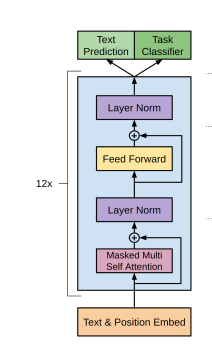

### Transformer 디코더 구성
- 논문에서 언급된 “multi-layer Transformer decoder”는 아래 코드에서 구현
- 여기서 디코더는 입력 시퀀스에서 다음 토큰의 확률 분포를 계산
- Decoder Layer 는 그림대로 12개로 설정
- multi-head num 은 8개로 설정

In [35]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    """
    디코더 레이어를 정의하는 함수.

    Args:
    - units: Feed Forward Network의 히든 유닛 수.
    - d_model: 임베딩 및 모델 출력 차원.
    - num_heads: Multi-Head Attention의 헤드 수.
    - dropout: 드롭아웃 비율.

    Returns:
    - 디코더 레이어 (Keras Model).
    """
    # 디코더 입력 (임베딩된 시퀀스)
    # shape: (batch_size, seq_len, d_model)
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # Look-Ahead 마스크: 미래 정보를 차단
    # shape: (batch_size, 1, seq_len, seq_len)
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")

    # 멀티 헤드 어텐션: 디코더 입력에 대해 Self-Attention 수행
    # attention shape: (batch_size, seq_len, d_model)
    attention = MultiHeadAttention(d_model, num_heads)(inputs={
        "query": inputs, "key": inputs, "value": inputs, "mask": look_ahead_mask
    })

    # Residual Connection + Layer Normalization
    # shape: (batch_size, seq_len, d_model)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + inputs)

    # Feed Forward Network (FFN): 완전 연결층
    # 첫 번째 FFN 레이어
    # shape: (batch_size, seq_len, units)
    outputs = tf.keras.layers.Dense(units, activation="relu")(attention)

    # 두 번째 FFN 레이어
    # shape: (batch_size, seq_len, d_model)
    outputs = tf.keras.layers.Dense(d_model)(outputs)

    # Residual Connection + Layer Normalization
    # shape: (batch_size, seq_len, d_model)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention)

    # 디코더 레이어 반환
    return tf.keras.Model([inputs, look_ahead_mask], outputs, name=name)

### 디코더 층을 쌓아 디코더 만들기

In [36]:
def decoder(vocab_size, num_layers, units, d_model, num_heads, dropout):
    """
    디코더를 정의하는 함수.

    Args:
    - vocab_size: 어휘 크기.
    - num_layers: 디코더 레이어의 수.
    - units: Feed Forward Network의 히든 유닛 수.
    - d_model: 임베딩 및 모델 출력 차원.
    - num_heads: Multi-Head Attention의 헤드 수.
    - dropout: 드롭아웃 비율.

    Returns:
    - 디코더 (Keras Model).
    """
    # 디코더 입력: 정수형 토큰 시퀀스
    # shape: (batch_size, seq_len)
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # Look-Ahead 마스크: 미래 정보를 차단
    # shape: (batch_size, 1, seq_len, seq_len)
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    
    # 임베딩 레이어: 정수형 토큰을 실수형 벡터로 변환
    # shape: (batch_size, seq_len, d_model)
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))  # 스케일링

    # 포지셔널 인코딩: 위치 정보를 추가
    # shape: (batch_size, seq_len, d_model)
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # 드롭아웃: 과적합 방지를 위해 일부 뉴런 비활성화
    # shape: (batch_size, seq_len, d_model)
    outputs = tf.keras.layers.Dropout(dropout)(embeddings)

    # 디코더 레이어를 순차적으로 쌓음
    for i in range(num_layers):
        # 각 레이어에 고유한 이름 부여
        # shape: (batch_size, seq_len, d_model)
        outputs = decoder_layer(units, d_model, num_heads, dropout, name=f"decoder_layer_{i}")(
            [outputs, look_ahead_mask]
        )

    # 디코더 반환
    # outputs shape: (batch_size, seq_len, d_model)
    return tf.keras.Model([inputs, look_ahead_mask], outputs, name="decoder")

### 모델 정의 및 학습하기

1.	디코더 레이어 입력/출력:
- 입력: (batch_size, seq_len, d_model)
- 출력: (batch_size, seq_len, d_model)
2.	디코더 입력/출력:
- 입력: (batch_size, seq_len) → 임베딩 후 (batch_size, seq_len, d_model)
- 출력: (batch_size, seq_len, d_model)
3.	Transformer 입력/출력:
- 입력: (batch_size, seq_len)
- 출력: (batch_size, seq_len, vocab_size)

In [37]:
def transformer(vocab_size, num_layers, units, d_model, num_heads, dropout):
    """
    GPT 모델 정의 (디코더 기반).

    Args:
    - vocab_size: 어휘 크기.
    - num_layers: 디코더 레이어의 수.
    - units: Feed Forward Network의 히든 유닛 수.
    - d_model: 임베딩 및 모델 출력 차원.
    - num_heads: Multi-Head Attention의 헤드 수.
    - dropout: 드롭아웃 비율.

    Returns:
    - GPT 모델 (Keras Model).
    """
    # 디코더 입력: 정수형 토큰 시퀀스
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # Look-Ahead 마스크 생성
    look_ahead_mask = tf.keras.layers.Lambda(create_look_ahead_mask, name="look_ahead_mask")(inputs)

    # 디코더 정의
    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )([inputs, look_ahead_mask])

    # 출력 레이어: 디코더의 출력을 어휘 크기 차원으로 변환
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    # GPT 모델 반환
    return tf.keras.Model(inputs=inputs, outputs=outputs, name="GPT")

### 모델 생성

In [38]:
tf.keras.backend.clear_session()

# 하이퍼파라미터 수정
NUM_LAYERS = 12  # GPT 논문의 디코더 레이어의 반복 수
D_MODEL = 256    # 임베딩 및 모델 출력 차원
NUM_HEADS = 8    # 멀티 헤드 어텐션의 헤드 수
UNITS = 512      # Feed Forward Network의 히든 유닛 수
DROPOUT = 0.1    # 드롭아웃 비율

# GPT 모델 정의
model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,  # 디코더 레이어 반복 수를 12로 설정
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT
)

# 모델 요약 출력
model.summary()

Model: "GPT"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
look_ahead_mask (Lambda)        (None, 1, None, None 0           inputs[0][0]                     
__________________________________________________________________________________________________
decoder (Functional)            (None, None, 256)    8417024     inputs[0][0]                     
                                                                 look_ahead_mask[0][0]            
__________________________________________________________________________________________________
outputs (Dense)                 (None, None, 8171)   2099947     decoder[0][0]                  

### 손실 함수(Loss function)

In [39]:
# 1. 손실 함수 정의
def loss_function(y_true, y_pred):
    """
    손실 함수: SparseCategoricalCrossentropy를 기반으로, 패딩된 위치를 무시하도록 설정.

    Args:
    - y_true: 실제 정답 데이터 (정수형 인덱스).
    - y_pred: 모델 출력 (로짓).

    Returns:
    - 평균 손실 값 (스칼라).
    """
    # y_true의 shape를 (batch_size, seq_len - 1)로 조정
    # MAX_LENGTH는 시퀀스의 최대 길이
    # 예: (batch_size, target_seq_len) -> (batch_size, target_seq_len - 1)
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

    # SparseCategoricalCrossentropy를 사용하여 손실 계산
    # y_true: 정수 인덱스 형태의 정답 데이터 (shape: (batch_size, target_seq_len - 1))
    # y_pred: 모델의 출력 (shape: (batch_size, target_seq_len - 1, vocab_size))
    # from_logits=True: y_pred가 소프트맥스 이전의 logits 임을 지정
    # reduction='none': 각 토큰의 손실 값을 반환 (shape: (batch_size, target_seq_len - 1))
    # 손실 함수를 호출할 때, reduction='none'을 설정하면 각 데이터 포인트에 대한 손실 값을 반환
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

    # 패딩 위치를 무시하기 위한 마스크 생성
    # tf.not_equal(y_true, 0): y_true에서 0(패딩 위치)이 아닌 위치를 True로 표시
    # tf.cast(..., tf.float32): True -> 1.0, False -> 0.0으로 변환
    # mask의 shape: (batch_size, target_seq_len - 1)
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)

    # 손실 값에 마스크 적용
    # loss와 mask를 element-wise로 곱함
    # 패딩 위치의 손실 값은 0으로 설정
    # masked loss의 shape: (batch_size, target_seq_len - 1)
    loss = tf.multiply(loss, mask)

    # 평균 손실 반환
    # 모든 유효한 위치의 손실 값을 평균하여 최종 손실 반환
    # 최종 반환 값은 스칼라 값
    return tf.reduce_mean(loss)

### 커스텀 된 학습률(Learning rate)  
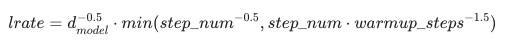

In [40]:
# 학습률 스케줄링 클래스 정의
# Transformer 모델에서 학습률을 조절하기 위해 사용하는 Custom Learning Rate Schedule
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        """
        CustomSchedule 초기화 함수

        Args:
        - d_model: 모델의 임베딩 차원 (d_model).
        - warmup_steps: 워밍업 스텝 수 (default=4000). 학습 초기 단계에서 학습률을 천천히 증가시키기 위한 설정.
        """
        super(CustomSchedule, self).__init__()

        # 모델의 임베딩 차원
        self.d_model = d_model
        # d_model 값을 float32 타입으로 변환 (TensorFlow에서 float32 연산을 위해)
        self.d_model = tf.cast(self.d_model, tf.float32)

        # 워밍업 단계의 스텝 수
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        """
        학습률 계산 함수

        Args:
        - step: 현재 학습 스텝

        Returns:
        - 학습률 (Learning Rate)
        """
        # 1. 현재 스텝(step)의 역제곱근 (step^-0.5)
        arg1 = tf.math.rsqrt(step)

        # 2. 워밍업 단계에서 스텝을 기준으로 한 학습률 증가 값 (step * (warmup_steps^-1.5))
        arg2 = step * (self.warmup_steps**-1.5)

        # 3. d_model의 역제곱근에 최소값(minimum)을 곱하여 학습률 결정
        #    학습률 = d_model^-0.5 * min(step^-0.5, step * warmup_steps^-1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [41]:
# 1. 학습률 스케줄 정의
# CustomSchedule 클래스 인스턴스를 생성하여 학습률 스케줄링 설정
# D_MODEL은 모델의 임베딩 차원 (예: 128, 512 등)
learning_rate = CustomSchedule(D_MODEL)

# 2. Adam 옵티마이저 정의
# Transformer 논문에서 제안된 Adam 옵티마이저 설정
# 학습률 스케줄(learning_rate), beta_1, beta_2, epsilon 값은 논문에 명시된 대로 설정
optimizer = tf.keras.optimizers.Adam(
    learning_rate=learning_rate,  # 학습률 스케줄 사용
    beta_1=0.9,                   # 1차 모멘트 추정(평균)에 대한 가중치
    beta_2=0.98,                  # 2차 모멘트 추정(분산)에 대한 가중치
    epsilon=1e-9                  # 숫자 안정성 확보를 위한 작은 값
)

# 3. 정확도(Accuracy) 정의
def accuracy(y_true, y_pred):
    """
    정확도를 계산하는 함수.
    Args:
    - y_true: 실제 정답 데이터 (정수형 인덱스).
    - y_pred: 모델이 예측한 확률 분포 (로짓 또는 소프트맥스 결과).

    Returns:
    - 정확도 (배치 내에서 올바르게 예측된 비율).
    """
    # y_true의 shape를 (batch_size, target_seq_len - 1)로 조정
    # MAX_LENGTH는 시퀀스의 최대 길이
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

    # sparse_categorical_accuracy는 정수 레이블(y_true)과 예측 확률(y_pred)을 비교하여 정확도를 계산
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

# 4. 모델 컴파일
# 옵티마이저, 손실 함수, 정확도를 설정하여 모델을 컴파일
model.compile(
    optimizer=optimizer,      # 학습률 스케줄을 포함한 Adam 옵티마이저
    loss=loss_function,       # 커스텀 손실 함수 (패딩 마스크 포함)
    metrics=[accuracy]        # 정확도 측정 함수
)
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [42]:
# 학습 실행
EPOCHS = 50
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/50
185/185 [==============================] - 29s 91ms/step - loss: 2.8839 - accuracy: 0.0335
Epoch 2/50
185/185 [==============================] - 17s 92ms/step - loss: 2.4573 - accuracy: 0.0719
Epoch 3/50
185/185 [==============================] - 17s 92ms/step - loss: 2.1771 - accuracy: 0.0758
Epoch 4/50
185/185 [==============================] - 17s 92ms/step - loss: 2.0480 - accuracy: 0.0790
Epoch 5/50
185/185 [==============================] - 17s 93ms/step - loss: 1.9719 - accuracy: 0.0818
Epoch 6/50
185/185 [==============================] - 17s 92ms/step - loss: 1.9153 - accuracy: 0.0843
Epoch 7/50
185/185 [==============================] - 17s 92ms/step - loss: 1.8622 - accuracy: 0.0874
Epoch 8/50
185/185 [==============================] - 17s 92ms/step - loss: 1.8097 - accuracy: 0.0904
Epoch 9/50
185/185 [==============================] - 17s 92ms/step - loss: 1.7543 - accuracy: 0.0934
Epoch 10/50
185/185 [==============================] - 17s 93ms/step - loss: 1.702

In [43]:
def decoder_inference(sentence):
    """
    주어진 입력 문장에 대해 디코더를 사용해 예측된 결과를 반환하는 함수.

    Args:
    - sentence: 입력 문장 (텍스트).

    Returns:
    - 모델이 예측한 텍스트 결과.
    """
    # 입력 문장 전처리 및 토큰화
    sentence = preprocess_sentence(sentence)
    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0
    )
    
    # 디코더 입력 시퀀스 초기화 (START_TOKEN으로 시작)
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    for i in range(MAX_LENGTH):
        # 디코더에 현재 시퀀스를 입력하여 다음 토큰 예측
        predictions = model(output_sequence, training=False)
        predictions = predictions[:, -1:, :]  # 마지막 타임스텝의 출력만 선택

        # 현재 타임스텝에서 예측된 토큰 ID
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 종료 토큰을 예측한 경우 반복 종료
        if predicted_id.numpy()[0][0] == END_TOKEN[0]:
            break

        # 예측된 토큰을 출력 시퀀스에 추가
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    # 최종 출력 시퀀스 반환
    return tf.squeeze(output_sequence, axis=0)

In [44]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence

In [45]:
sentence_generation('너의 취미는 뭐야?')

입력 : 너의 취미는 뭐야?
출력 : 좋아하는 사람 생기면 자꾸 따라하게 돼.자연스러운 현상입니다.


'좋아하는 사람 생기면 자꾸 따라하게 돼.자연스러운 현상입니다.'

In [46]:
# 테스트 문장
test_sentences = [
    "너는 누구니?",
    "너의 이름은 뭐니?",
    "내일 비가 올 거 같아?",
    "오늘의 점심 메뉴를 추천해줘",
    "네가 가장 잘 하는 것은 뭐니?"
]

# 테스트 실행
for sentence in test_sentences:
    print("\n=== 테스트 ===")
    sentence_generation(sentence)


=== 테스트 ===
입력 : 너는 누구니?
출력 : 좋아하는 사람 생기면 자꾸 따라하게 돼.자연스러운 현상입니다.

=== 테스트 ===
입력 : 너의 이름은 뭐니?
출력 : 좋아하는 사람 생기면 자꾸 따라하게 돼.자연스러운 현상입니다.

=== 테스트 ===
입력 : 내일 비가 올 거 같아?
출력 : 좋아하는 사람 생기면 자꾸 따라하게 돼.자연스러운 현상입니다.

=== 테스트 ===
입력 : 오늘의 점심 메뉴를 추천해줘
출력 : 좋아하는 사람 생기면 자꾸 따라하게 돼.자연스러운 현상입니다.

=== 테스트 ===
입력 : 네가 가장 잘 하는 것은 뭐니?
출력 : 좋아하는 사람 생기면 자꾸 따라하게 돼.자연스러운 현상입니다.


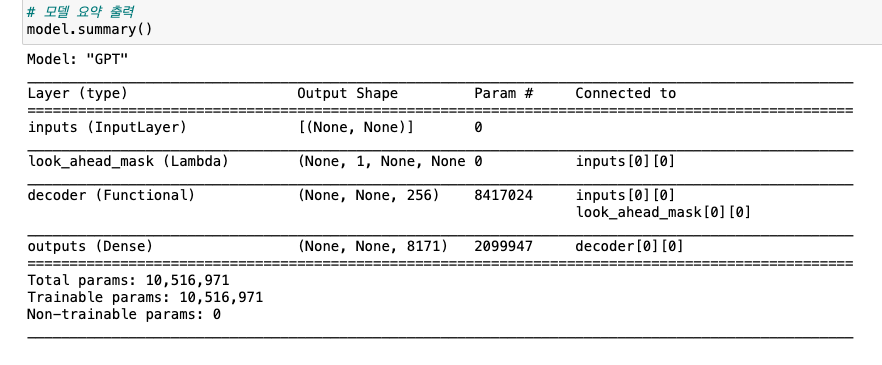

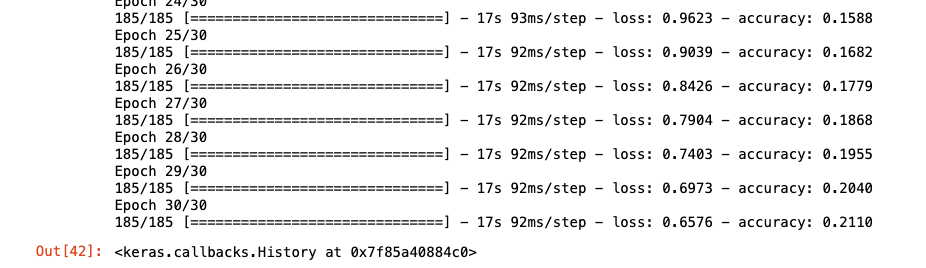

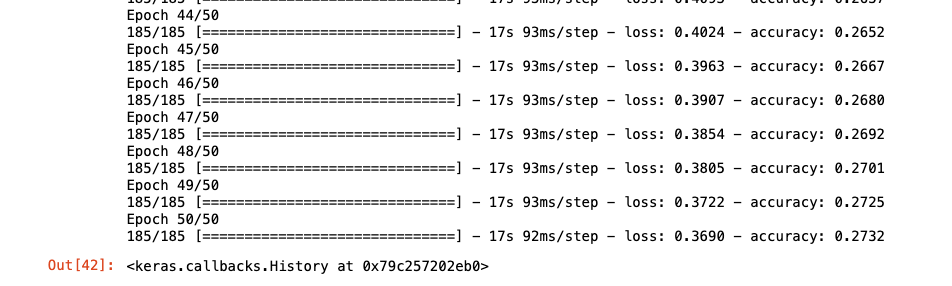

### 회고
1. 모든 입력 토큰에 대해 출력이 같은 토큰을 생성하고 있다.
2. Supervised fine-tuning 을 완성 해야 하는가?
3. 논문의 Unsupervised pre-training 부분이 제대로 구현 되어 있는지 검증이 필요하다.
4. decoder_inference 함수 구현이 적절한지도 확인도 필요 할 거 같다.
5. EPOCHS 수를 많이 늘려서 test 하기에는 학습 시간이 많이 걸려서 30번으로 제한하였다.
    - 50 으로 늘려서 다시 학습 함
6. input, output shape 이 아직도 헷갈린다.
7. 언어 모델은 모델을 평가하는 부분에서도 이해가 많이 필요 할 거 같다.
8. 논문을 보다 보니 Delim 토큰을 사용하여 두 문장을 연결 하는 구조를 확인 하였다.
9. 데이터셋을 위 구조로 변경하여 모델을 학습 하고 다시 test 하였다.
10. 다만 출력이 같은 토큰을 반복해서 생성하는 문제는 여전하다.
11. Delim 토큰으로 전처리 하는것이 맞는지는 확실하지 않다.
    - 논문을 보면 Entilment, Similarity, Multiple Choice task 에는 전부 사용한것으로 보인다.

### [QUEST 평가기준]

1. Transformer와 비교해 변경이 필요한 부분을 서술하였다.
    - 제출 노트북 파일 첫부분에 텍스트 블럭으로 서술합니다. 아키텍쳐 상 변경사항을 블럭단위로 서술합니다.  
    - 코드블럭에 변경사항을 주석으로 표시합니다.
2. 모델의 입력 형태에 맞게 전처리를 수행하였다.
    - Decoder 기반의 생성모델임을 감안하여 챗봇 데이터를 변형합니다.
    - 이번 과제는 pretrain을 위한 데이터셋과 학습만 고려합니다.
3. 모델의 입력 블럭을 GPT 논문에 기반하여 수정하였다.
    - 모델의 input이 정상적으로 구성되었는지 확인합니다.
    - 데이터에 위치 정보를 추가하는 과정을 구현합니다.
4. GPT 모델을 정상적으로 구성하였다.(model.summary, model.fit 결과 캡쳐 첨부)
    - 노드의 transformer 코드를 수정하여 GPT1 모델을 구성합니다. 
5. 입력에 따른 출력이 생성되었다.
    - 출력 결과물의 수준에 상관없이 모델이 정상적으로 동작하는지 확인합니다.
